In [1]:
import os
import pickle
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from matplotlib.colors import Normalize
from sklearn.preprocessing import StandardScaler
from utils import REL_METRICS_

fontsize = 36

In [2]:
COLORS = sns.color_palette('deep')
MODELS = ['puresvd', 'multidae', 'multivae', 'betavae', 'macridvae']
DATASETS = ['AmazonCD', 'ML1M', 'Yelp', 'GoodReadsChildren']
SEEDS = [41, 53, 61, 67, 71]
K = [10]
DIS_METRICS_ = ['disentanglement', 'completeness']
EXP_METRICS_ = ['lime', 'shap']
METRICS = [f'{m}_{k}' for m in REL_METRICS_ for k in K] + DIS_METRICS_ + EXP_METRICS_
MODEL2PDF = {
    'multidae': 'MultiDAE',
    'multivae': 'MultiVAE',
    'betavae': '$\\beta$-VAE',
    'macridvae': 'MacridVAE',
    'toppop': 'Top-Popular',
    'puresvd': 'PureSVD'
}
METRIC2PDF = {f'{m}_{k}': f'{m.upper()}@{k}' for m in REL_METRICS_ for k in K}
METRIC2PDF.update({
    'disentanglement': 'DISENTANGLEMENT',
    'completeness': 'COMPLETENESS',
    'shap': 'SHAP-global',
    'lime': 'LIME-global'

})
SEED2PDF = {SEEDS[i]: f'Seed {i+1}' for i in range(len(SEEDS))}
MODEL2COLOR = dict(zip([MODEL2PDF[mo] for mo in MODELS], COLORS[1:len(MODELS)+1]))
DATASET2PDF = {
    'ML1M': 'ML1M',
    'GoodReadsChildren': 'GR-Children',
    'Yelp': 'Yelp',
    'AmazonCD': 'Amazon-CD'
}
DATASET2COLOR = dict(zip([DATASET2PDF[ds] for ds in DATASETS], COLORS[1:len(DATASETS)+1]))
scaler = StandardScaler()

In [5]:
results = pd.DataFrame({**{METRIC2PDF[m]: []for m in METRICS}, **{'DATASET': [], 'MODEL': [], 'seed': []}})
for ds in DATASETS:
    for model in MODELS:
        for seed in SEEDS:
            path = os.path.join('experiments', 'evaluations', f'{model}-{ds}-{seed}-ndcg-1_0-50')
            score_names = []
            score_values = []
            for m in METRICS:
                file = os.path.join(path, f'{m}.txt')
                score_names.append(METRIC2PDF[m])
                score_values.append(abs(float(open(file).readline())))
            # score_values = scaler.fit_transform(np.array(score_values).reshape(-1, 1))
            scores = dict(zip(score_names, score_values))
            row = {**{'DATASET': DATASET2PDF[ds], 'MODEL': MODEL2PDF[model], 'seed': seed}, **scores}
            results = results._append(row, ignore_index=True)

In [6]:
def custom_heatmap(data, **kwargs):
    corr_order = ['NDCG@10', 'RECALL@10', 'MRR@10', 'COVERAGE@10', 'DISENTANGLEMENT', 'COMPLETENESS', 'LIME-global', 'SHAP-global']
    rvalues = []
    pvalues = []
    for mi in corr_order:
        row_rvalues = []
        row_pvalues = []
        for mj in corr_order:
            if mi == mj:
                row_rvalues.append(1.0)
                row_pvalues.append('1.0*')
            else:
                rmcorr = pg.rm_corr(data=data, x=mi, y=mj, subject=kwargs['subject'])
                rmcorr = rmcorr.iloc[0]
                r = rmcorr['r']
                pval = rmcorr['pval']
                row_rvalues.append(r)
                row_pvalues.append(f'{r:.2f}' + ('*' if pval < 0.05 else ''))
        rvalues.append(row_rvalues)
        pvalues.append(row_pvalues)
    rvalues = np.array(rvalues)
    pvalues = np.array(pvalues)
    rdf = pd.DataFrame(rvalues, index=corr_order, columns=corr_order)
    mask = np.triu(np.ones_like(rdf, dtype=bool))
    cmap = sns.diverging_palette(30, 180, as_cmap=True)
    return sns.heatmap(rdf.iloc[1:, :-1], mask=mask[1:, :-1], cmap=cmap, center=0, square=True, linewidths=.5, annot=pvalues[1:, :-1], vmax=1, vmin=-1, fmt='s', annot_kws={'fontsize': kwargs['fontsize']}, cbar=False)

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


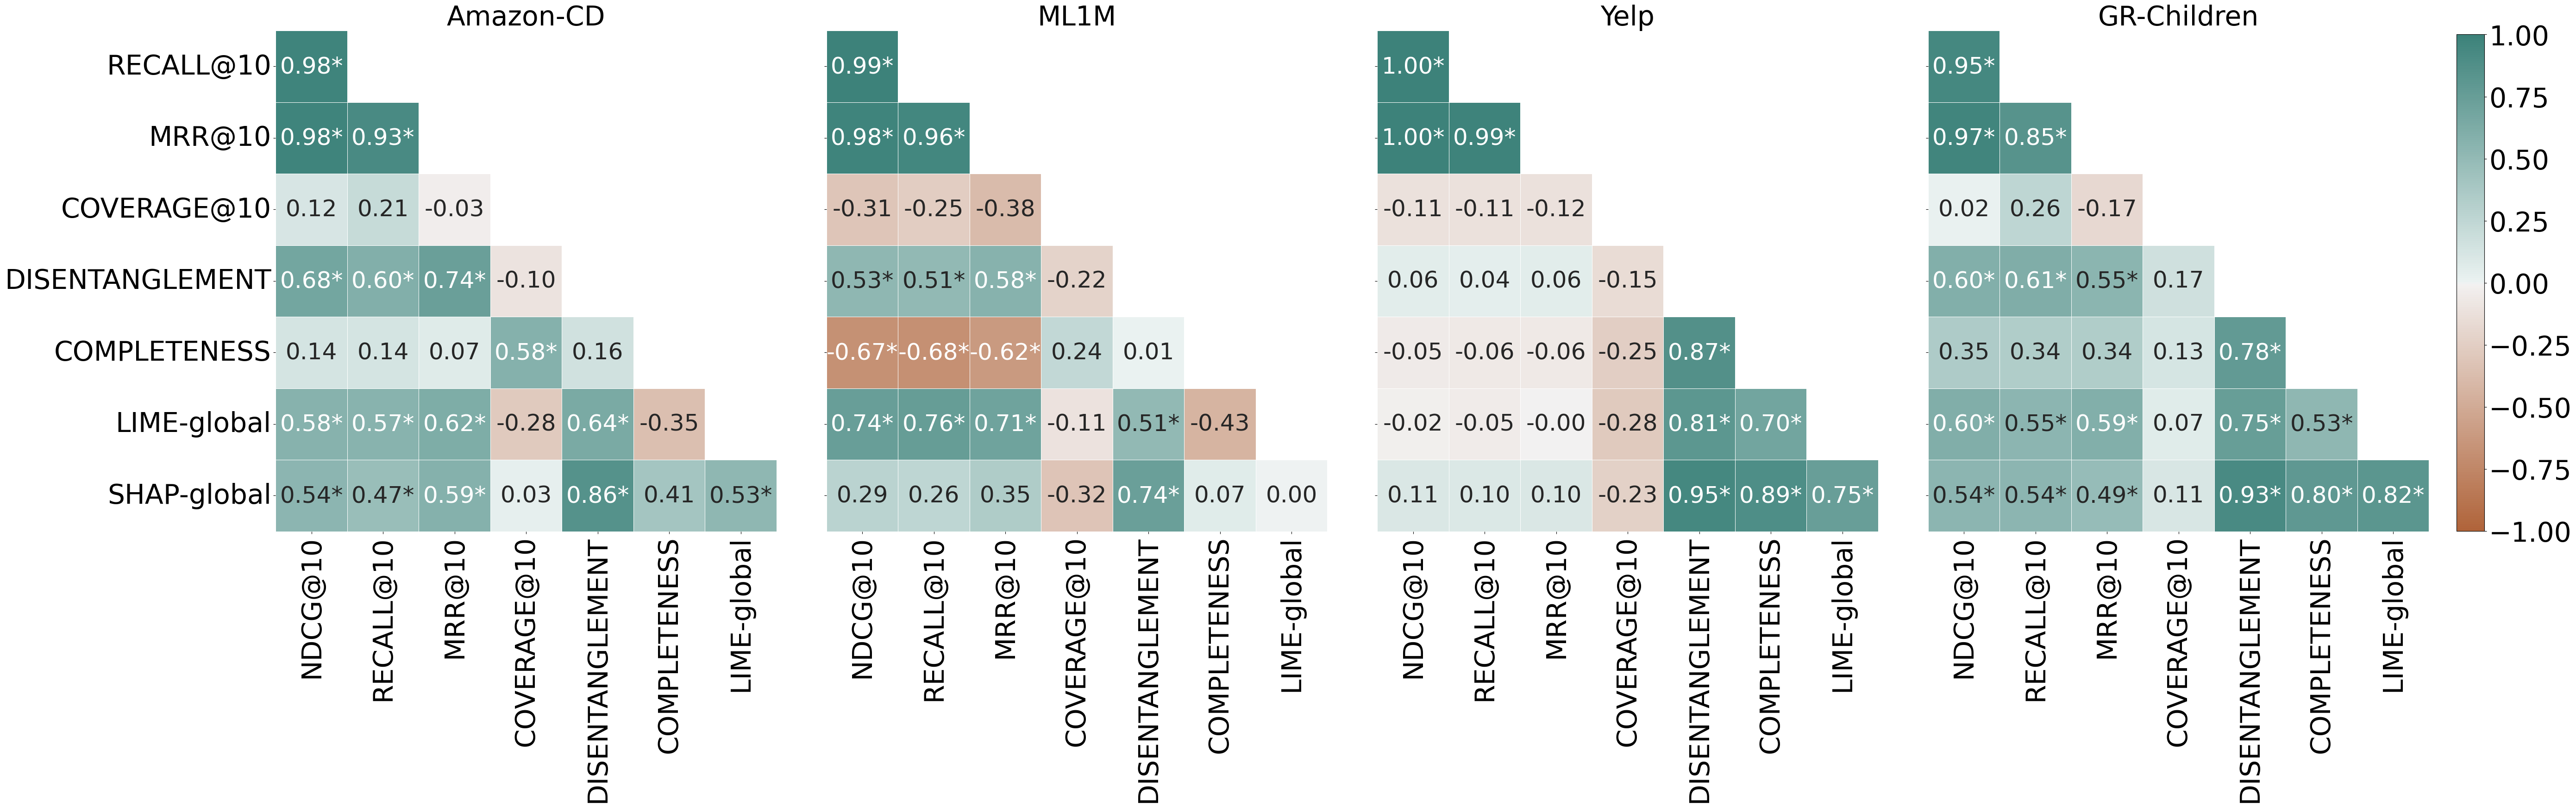

In [7]:
labelsize = 42
numbersize = 36
col = 'DATASET'
subject_dict = {'MODEL': 'DATASET', 'DATASET': 'MODEL'}
col_order = {'DATASET': [DATASET2PDF[df] for df in DATASETS], 'MODEL': [MODEL2PDF[mo] for mo in MODELS]}

g = sns.FacetGrid(results, col=col, sharey=True, height=15, aspect=1, col_order=col_order[col], gridspec_kws={'wspace': 0.1});
g.set_titles(template='{col_name}')
g.set_xticklabels(g.axes[0][0].get_xticklabels(), fontsize=labelsize)
g.set_yticklabels(g.axes[0][0].get_yticklabels(), fontsize=labelsize)
for ax in g.axes[0]:
    ax.set_title(ax.get_title(), fontsize=labelsize)

palette = 'TealBrown'
g.map_dataframe(custom_heatmap, data=results, subject=subject_dict[col], palette=palette, fontsize=numbersize)
sm = plt.cm.ScalarMappable(norm=Normalize(vmin=-1, vmax=1), cmap=sns.diverging_palette(30, 180, as_cmap=True))
g.figure.subplots_adjust(right=0.9)
cbar_ax = g.figure.add_axes([0.91, 0.135, 0.01, 0.715])
cbar_ax.tick_params(labelsize=labelsize)
cbar = g.figure.colorbar(sm, cax=cbar_ax)
cbar.solids.set_rasterized(False)
cbar.solids.set_edgecolor("face")
g.figure.savefig(f'rmcorr_{col}_{palette}.eps', format='eps', dpi=800, bbox_inches='tight')

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


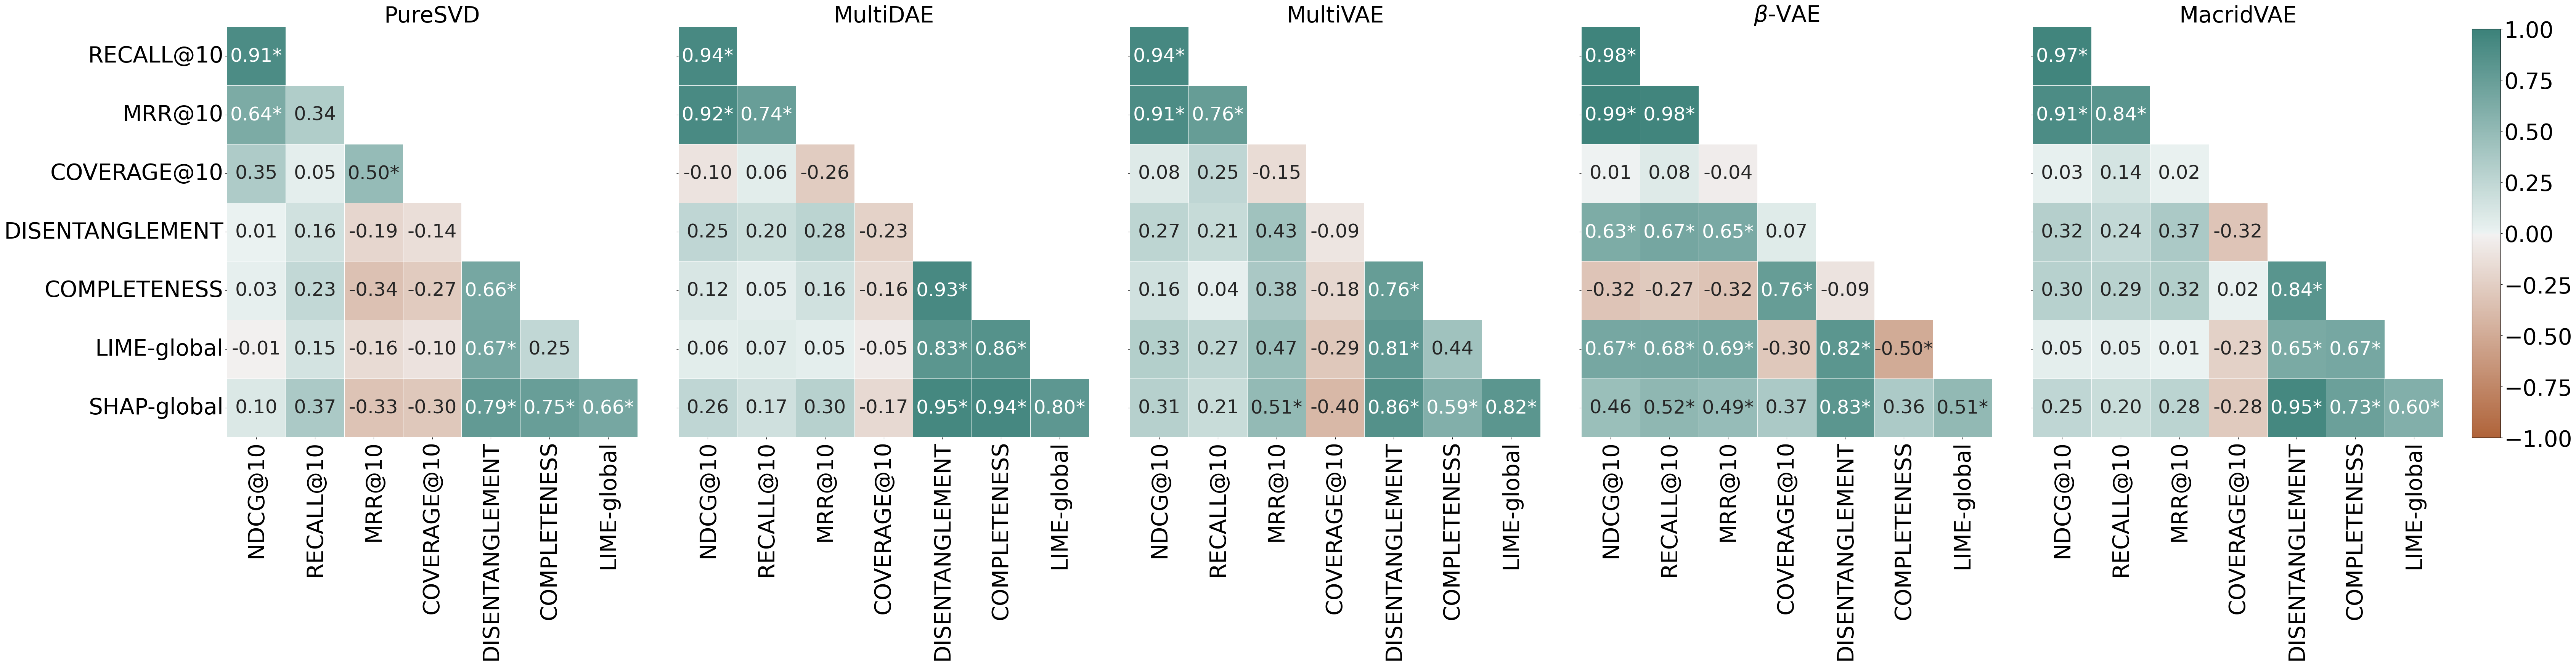

In [8]:
labelsize = 42
numbersize = 36
col = 'MODEL'
subject_dict = {'MODEL': 'DATASET', 'DATASET': 'MODEL'}
col_order = {'DATASET': [DATASET2PDF[df] for df in DATASETS], 'MODEL': [MODEL2PDF[mo] for mo in MODELS]}

g = sns.FacetGrid(results, col=col, sharey=True, height=15, aspect=1, col_order=col_order[col], gridspec_kws={'wspace': 0.1});
g.set_titles(template='{col_name}')
g.set_xticklabels(g.axes[0][0].get_xticklabels(), fontsize=labelsize)
g.set_yticklabels(g.axes[0][0].get_yticklabels(), fontsize=labelsize)
for ax in g.axes[0]:
    ax.set_title(ax.get_title(), fontsize=labelsize)

palette = 'TealBrown'
g.map_dataframe(custom_heatmap, data=results, subject=subject_dict[col], palette=palette, fontsize=numbersize)
sm = plt.cm.ScalarMappable(norm=Normalize(vmin=-1, vmax=1), cmap=sns.diverging_palette(30, 180, as_cmap=True))
g.figure.subplots_adjust(right=0.9)
cbar_ax = g.figure.add_axes([0.91, 0.135, 0.01, 0.715])
cbar_ax.tick_params(labelsize=labelsize)
cbar = g.figure.colorbar(sm, cax=cbar_ax)
cbar.solids.set_rasterized(False)
cbar.solids.set_edgecolor("face")
g.figure.savefig(f'rmcorr_{col}_{palette}.eps', format='eps', dpi=800, bbox_inches='tight')